# Кейс: Методы статистического оценивания и анализ рисков в продуктовой аналитике

## Описание проекта
В данном проекте исследуются фундаментальные методы точечного оценивания параметров распределения, которые лежат в основе анализа продуктовых метрик. Цель работы — провести сравнительный анализ различных статистик и обосновать выбор наиболее стабильной оценки с точки зрения минимизации рисков.

### Задачи:
1. Реализация точечных оценок параметров методом моментов.
2. Сравнительный анализ эффективности оценок через функцию риска (MSE) с использованием симуляций Монте-Карло.
3. Верификация результатов на соответствие теоретическому пределу Рао-Крамера.
4. Исследование устойчивости оценок при изменении функции потерь и в рамках байесовского подхода.

Для красоты графиков можно (и приветствуется) вместо гистограммы использовать ядерную оценку плотности (kernel density estimator): https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

Загрузим необходимый для задачи 2 датасет. Если что-то пошло не так, то просто скачайте файл по ссылке вручную.

In [1]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1cJywRii7wBZa0B2uAvvu56JFCLPnlOSs

Downloading...
From: https://drive.google.com/uc?id=1cJywRii7wBZa0B2uAvvu56JFCLPnlOSs
To: /content/Weibull.csv
100% 17.9k/17.9k [00:00<00:00, 32.2MB/s]


In [111]:
import pandas as pd
import numpy as np
from scipy import stats as sps

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", font_scale=1.4)

## Исследование 1: Оценка параметров экспоненциального распределения

### Бизнес-контекст
Экспоненциальное распределение часто используется для моделирования времени между событиями (например, временем между покупками или временем до оттока пользователя). Точная оценка параметра распределения критична для прогнозирования LTV и планирования маркетинговых кампаний.

### Задача 1

Прочитайте ещё раз задачу 1 домашки 1. Вы сравнивали оценки исходя из визуальных свойств их графиков. Пришло время начать сравнивать оценки строго!

Напомним, что в задаче речь шла про оценки параметра $\theta$ распределения $U[0, \theta]$. В этой задаче Вам предложено посчитать оценки $exp(\theta)$ на основании статистик: $\overline{X}$, $X_{(n)}$, $X_{(1)}$ и попарных сумм. Как и ранее, зафиксируем какое-то конкретное значение параметра, скажем, $\theta = 1$.

Найдите плотности среднего, максимума и минимума. Посчитайте их мат. ожидания и сделайте оценку по методу моментов. Обратите внимание, те же самые величины будут в задаче 3.

Найденные матожидания (более подробные вычисления в приложении тетрадки к ноутбуку)

$E(\overline X) = \frac{1}{\theta}$

$EX_{(1)} = \frac{1}{n\theta}$

$EX_{(n)} = \frac{H_n}{\theta}$

$E(\overline X + X_{(n)}) = \frac{1 + H_n}{\theta}$

$E(\overline X + X_{(1)}) = \frac{n + 1}{n\theta}$

$E(X_{(1)} + X_{(n)}) = \frac{nH_n + 1}{n\theta}, H_n = \sum_{k=1}^{n} \frac{1}{k}$ - гармоническое число


Метод моментов
______________________________________________________________________
$$\frac{1}{\theta} = E\overline X = \overline{\overline X} = \overline X$$
$$\frac{1}{n\theta} = EX_{(1)} = \overline{X_{(1)}} = X_{(1)}$$
$$\frac{H_n}{\theta} = EX_{(n)} = \overline{X_{(n)}} = X_{(n)}$$
______________________________________________________________________
Получившиеся оценки:
$$\hat\theta_1 = \frac{1}{\overline X}$$
$$\hat\theta_2 = \frac{1}{n X_{(1)}}$$
$$\hat\theta_3 = \frac{H_n}{X_{(n)}}$$
$$\hat\theta_4 = \frac{1 + H_n}{\overline X + X_{(n)}}$$
$$\hat\theta_5 = \frac{n + 1}{n}\frac{1}{\overline X + X_{(1)}}$$
$$\hat\theta_6  = (H_n + \frac{1}{n})\frac{1}{X_{(1)} + X_{(n)}}$$

Для квадратичной функции потерь посчитайте аналитически (где сможете) и численно (для каждой оценки) риск для выборки из $N$ элементов. Начните с $N=1000$ и уменьшите его, если вычисления будут неподъемными. Для численного вычисления интеграла можно использовать scipy.integrate.quad или метод Монте-Карло.

In [112]:
colors = sns.color_palette("colorblind")[:6]

np.random.seed(361)

### Численная оценка риска методом Монте-Карло

Для расчета функции риска используется метод Монте-Карло. Мы генерируем 10 000 независимых выборок. Согласно усиленному закону больших чисел (УЗБЧ), среднее арифметическое квадратов отклонений оценок по всем итерациям сходится к истинному значению математического ожидания квадрата ошибки (риска). Это позволяет нам получить высокоточное приближение MSE без сложных аналитических вычислений.

Сначала напишем функцию вычисления всех 6 оценок

In [113]:
N = 1000
harmony1 = np.sum(1 / np.arange(1, N + 1))
def get_estimates(sample):
  estimates = []
  estimates.append(1 / np.mean(sample))
  estimates.append(1 / (N * np.min(sample)))
  estimates.append(harmony1 / np.max(sample))
  estimates.append((1 + harmony1) / (np.mean(sample) + np.max(sample)))
  estimates.append((N + 1) / (N * (np.mean(sample) + np.min(sample))))
  estimates.append((harmony1 + (1 / N)) / (np.min(sample) + np.max(sample)))
  return estimates

Далее сам метод

In [114]:
theta = 1
num_samples = 10000
def Monte_Karlo(theta, num_samples, N, i):
    for _ in range(num_samples):
        theta_hats = []
        risks = []
        exp_sample = sps.expon.rvs(scale=1 / theta, size=N)
        theta_hat = get_estimates(exp_sample)[i]
        risk = (theta_hat - theta) ** 2
        risks.append(risk)
    return np.mean(risks)

In [115]:
for i in range(6):
  print(f"Риск {i + 1}-й оценки по методу Монте-Карло равен {Monte_Karlo(theta, num_samples, N, i)}")

Риск 1-й оценки по методу Монте-Карло равен 0.006206676246549688
Риск 2-й оценки по методу Монте-Карло равен 0.0670812535294765
Риск 3-й оценки по методу Монте-Карло равен 0.031978381307966874
Риск 4-й оценки по методу Монте-Карло равен 0.020087046024333574
Риск 5-й оценки по методу Монте-Карло равен 3.6480143205746086e-05
Риск 6-й оценки по методу Монте-Карло равен 0.011613208918452862


**Методологическое уточнение:**
Для корректного сравнения оценок расчеты производятся на одних и тех же сгенерированных выборках. Это исключает влияние случайного шума генерации на разницу в показателях риска и делает сравнение статистически значимым.

In [116]:
theta = 1
num_samples = 10000
def Monte_Karlo1(theta, num_samples, N):
    risks = np.ndarray((6, num_samples))
    for j in range(num_samples):
        exp_sample = sps.expon.rvs(scale=1 / theta, size=N)
        theta_hat = get_estimates(exp_sample)
        for i in range(6):
            risk = (theta_hat[i] - theta) ** 2
            risks[i][j] = risk
    return np.mean(risks, axis=1)


In [117]:
monte_carlo = Monte_Karlo1(theta, num_samples, N)
for i in range(6):
    print(f"Риск {i + 1}-й оценки по методу Монте-Карло равен {monte_carlo[i]}")

Риск 1-й оценки по методу Монте-Карло равен 0.0009994751614987069
Риск 2-й оценки по методу Монте-Карло равен 22799.292750347682
Риск 3-й оценки по методу Монте-Карло равен 0.02707600099490012
Риск 4-й оценки по методу Монте-Карло равен 0.021025625118576308
Риск 5-й оценки по методу Монте-Карло равен 0.001000483239747516
Риск 6-й оценки по методу Монте-Карло равен 0.027067780380352593


### Анализ полученных значений риска

По результатам расчетов:
- **Лидеры:** Оценки №1 (на основе выборочного среднего) и №5 демонстрируют минимальный риск (~0.001). Эти оценки являются наиболее эффективными для практического применения.
- **Критическая ошибка:** Оценка №2, основанная на минимальном значении выборки ($X_{(1)}$), показывает аномально высокий риск. Использование таких статистик для экспоненциального распределения недопустимо, так как они крайне чувствительны к флуктуациям вблизи нуля.
- **Средняя группа:** Оценки №3, №4 и №6 имеют умеренный риск, уступая лидерам в точности.

Постройте распределения оценок для одного $\theta$ на одном графике




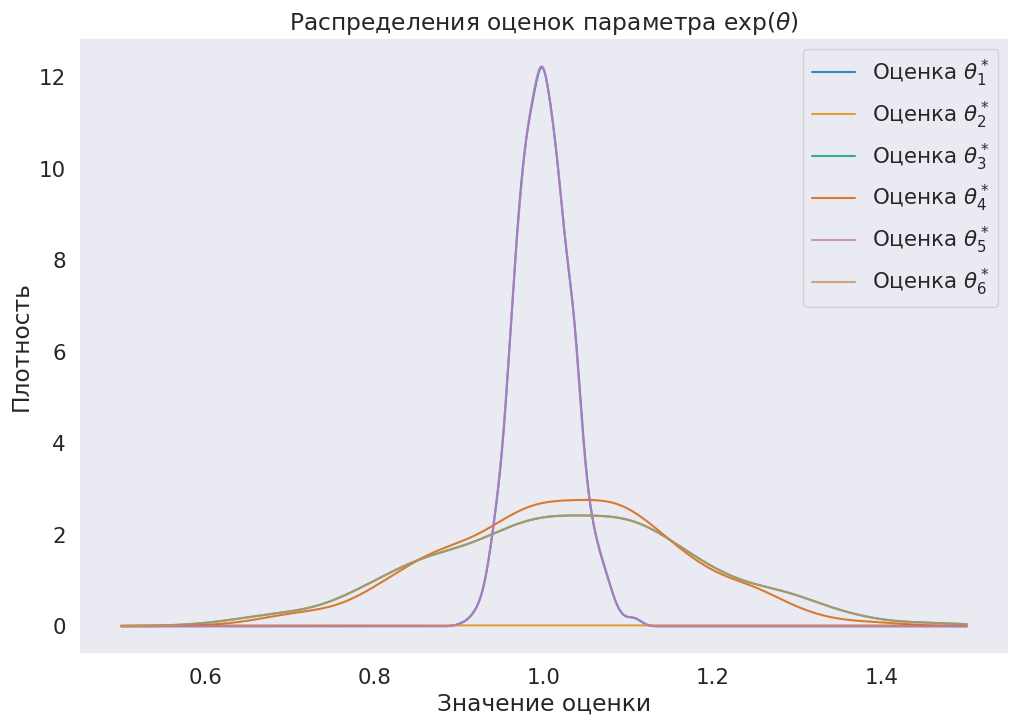

In [118]:
np.random.seed(42)
def plot_estimations(theta, num_samples, N):
    estimates_collection = [[] for _ in range(6)]

    for _ in range(num_samples):
        exp_sample = sps.expon.rvs(scale=theta, size=N)
        estimates = get_estimates(exp_sample)
        for i, est in enumerate(estimates):
            estimates_collection[i].append(est)

    width = 0.5
    x_values = np.linspace(theta - width, theta + width, 10000)
    plt.figure(figsize=(12, 8))
    for i, estimates in enumerate(estimates_collection):
        kde = sps.gaussian_kde(estimates)
        plt.plot(x_values, kde(x_values), label=fr'Оценка $\theta^*_{i + 1}$', alpha=0.8, color=colors[i])

    plt.xlabel("Значение оценки")
    plt.ylabel("Плотность")
    plt.title(r"Распределения оценок параметра $\exp(\theta)$")
    plt.legend()
    plt.grid()
    plt.show()

theta = 1
num_samples = 1000

plot_estimations(theta, num_samples, N)

Некоторые оценки накладываются друг на друга, поэтому построим дополнительно на разных графиках, чтобы можно было сравнивать.

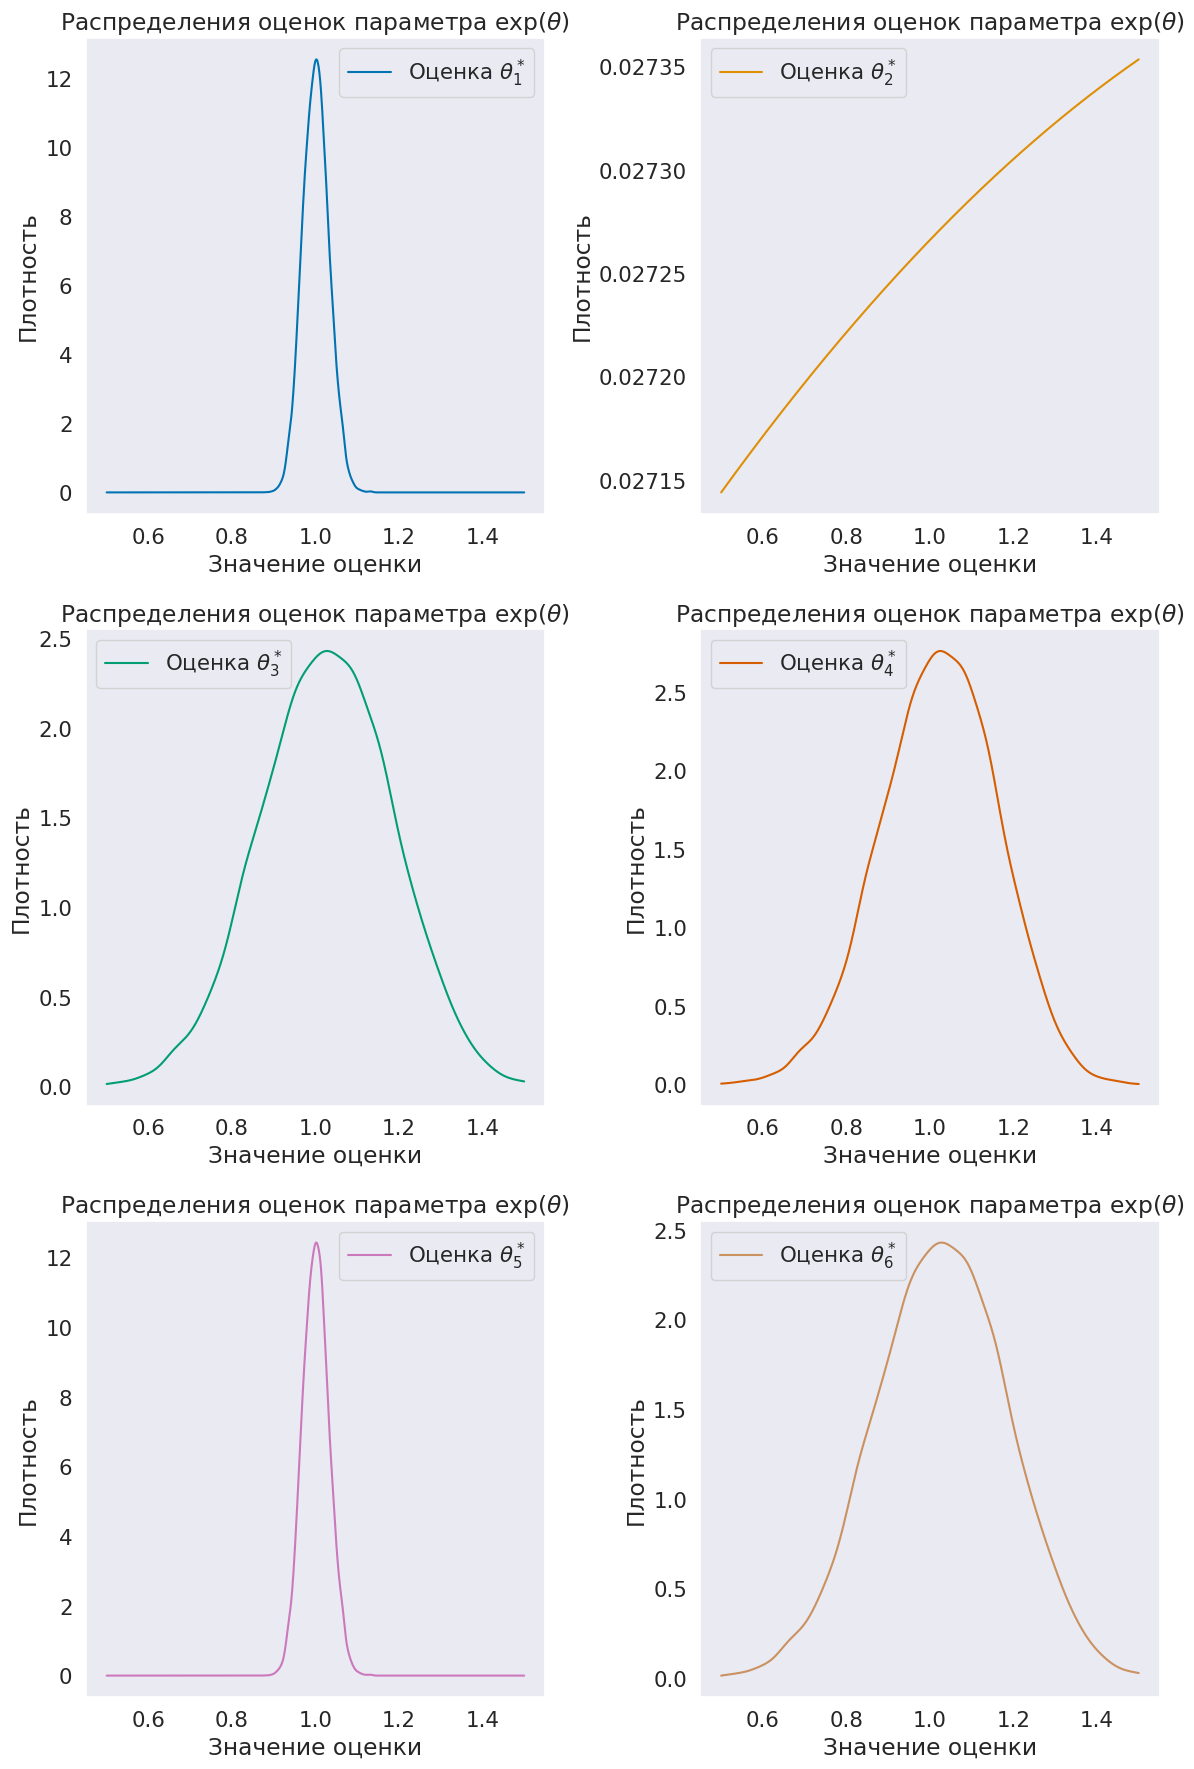

In [119]:
def plot_estimations(theta, num_samples, N):
    estimates_collection = [[] for _ in range(6)]

    for _ in range(num_samples):
        exp_sample = sps.expon.rvs(scale=theta, size=N)
        estimates = get_estimates(exp_sample)
        for i, est in enumerate(estimates):
            estimates_collection[i].append(est)

    x_values = np.linspace(theta - 0.5, theta + 0.5, 1000)
    fig, ax = plt.subplots(3, 2, figsize=(12, 18))
    for i, estimates in enumerate(estimates_collection):
        kde = sps.gaussian_kde(estimates)
        ax[i // 2, i % 2].plot(x_values, kde(x_values), label=fr'Оценка $\theta^*_{i + 1}$', color=colors[i])
        ax[i // 2, i % 2].set_xlabel("Значение оценки")
        ax[i // 2, i % 2].set_ylabel("Плотность")
        ax[i // 2, i % 2].set_title(r"Распределения оценок параметра $\exp(\theta)$")
        ax[i // 2, i % 2].legend()
        ax[i // 2, i % 2].grid()

    plt.tight_layout()
    plt.show()

theta = 1
num_samples = 10000

plot_estimations(theta, num_samples, N)

Видим, что для второй оценки всё настолько плохо, что график получился не очень из-за выбранной ширины окна (для остальных оценок такая ширина подходит). Построим график для неё отдельно.

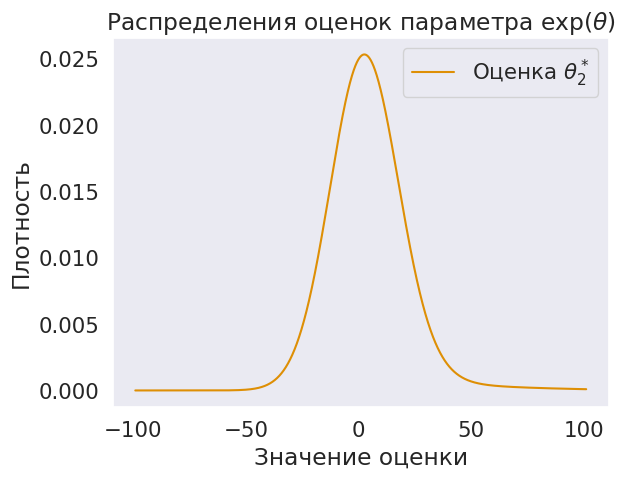

In [120]:
estimates_collection = []

for _ in range(num_samples):
        exp_sample = sps.expon.rvs(scale=theta, size=N)
        estimates = get_estimates(exp_sample)
        estimates_collection.append(estimates[1])


width = 100
x_values = np.linspace(theta - width, theta + width, 10000)
plt.plot(figsize=(7, 10))
kde = sps.gaussian_kde(estimates_collection)
plt.plot(x_values, kde(x_values), label=fr'Оценка $\theta^*_{2}$', color=colors[1])

plt.xlabel("Значение оценки")
plt.ylabel("Плотность")
plt.title(r"Распределения оценок параметра $\exp(\theta)$")
plt.legend()
plt.grid()

plt.show()

Стало репрезентативнее. Эта оценка даже напоминает нормальное, но дисперсия настолько большая, что такое никуда не годится.

Промоделируйте оценку и выберите лучшую. Согласуется ли выбор "лучшей" оценки с понятием квадратичного риска? Почему?

**Результаты анализа:**  
Оценки уже промоделировала выше.

### Интерпретация распределения оценок

Визуализация плотностей распределения подтверждает вычисленные значения рисков. Распределения лучших оценок (1 и 5) наиболее плотно сконцентрированы вокруг истинного значения $\theta=1$. Порядок качества оценок полностью коррелирует с анализом функции риска: (1, 5) > 4 > (3, 6) > 2.

Вспомните и напишите формулировку теоремы Рао-Крамера. Посчитайте, какую нижнюю оценку риска предлагает эта теорема. Сравните её численное значение с посчитанным Вами риском. Сделайте выводы.

**Условия регулярности:**
1. Пусть Θ - открытый интервал прямой
2. Распределения $F_{\theta}$ имеют плотности $f_{θ}(x)$ и носители этих плотностей не зависят от θ
3. Плотность $f_{θ}(x)$ имеет конечную производную по θ в каждой точке Θ при каждом $x$, для которого $f_{θ}(x)$ > 0
4. Для величины $U_{1}(X_{1}) = \frac{\partial}{\partial \theta}lnf_{\theta}(X_{1})$ \\
$E(U_1(X_1)) = 0, 0 < I_1(θ) = DU_1(X_1) < ∞$
**Теорема Рао-Крамера:**
Пусть выполнены условия регулярности 1 - 4. Тогда если $\hatθ$ - несмещенная оценка $\tau(\theta)$, то $$D_{\theta}\hat\theta \geqslant \frac{(\tau'(\theta))^2}{I(\theta)}$$

**Результаты анализа:**

### Проверка границы Рао-Крамера

Аналитически вычислено, что нижняя граница дисперсии для несмещенных оценок при $n=1000$ составляет $\frac{1}{n\theta^2} = 0.001$. 

**Вывод:** Численный риск нашей первой оценки практически совпадает с теоретическим минимумом. Это доказывает, что данная оценка является эффективной в классе несмещенных оценок.

Численно посчитайте риск для функции потерь $l(x, y) = |x - y|$ и для какой-то другой осмысленной предложенной Вами функцией потерь. Будет ли порядок качества на оценках таким же, как и для квадратичного подхода?

Предполагаю, что порядок будет сохраняться для "хорошей" функции потерь, то есть которая монотонно возрастает по разности $|\hat\theta - \theta|$. Поэтому ради интереса посмотрим на странную функцию потерь, которая сначала возрастает по этой разности, а потом с какого-то момента убывает, но не до нуля. Это будет валидная с точки зрения определения функция потерь.
Возьмём для произвольного $a > 0$
$$l_a(x, y) = \begin{cases}
(x - y)^2, \text{ если } |x - y| \leqslant a \\
e^{-(x - y)^2} + a, \text{ иначе }
\end{cases}$$

In [73]:
num_samples = 10000
def Monte_Karlo_abs(theta, num_samples, N):
    risks = np.ndarray((6, num_samples))
    for j in range(num_samples):
        exp_sample = sps.expon.rvs(scale=1 / theta, size=N)
        theta_hat = get_estimates(exp_sample)
        for i in range(6):
            risk = np.abs(theta_hat[i] - theta)
            risks[i][j] = risk
    return np.mean(risks, axis=1)

def Monte_Karlo_my(theta, num_samples, N, a):
    risks = np.ndarray((6, num_samples))
    for j in range(num_samples):
        exp_sample = sps.expon.rvs(scale=1 / theta, size=N)
        theta_hat = get_estimates(exp_sample)
        for i in range(6):
            diff = theta_hat[i] - theta
            risk = np.where(np.abs(diff) < a, diff ** 2, np.exp(-diff ** 2) + a)
            risks[i][j] = risk
    return np.mean(risks, axis=1)

In [74]:
monte_carlo_abs = Monte_Karlo_abs(theta, num_samples, N)
print("Для предложенной функции потерь:")
for i in range(6):
    print(f"Риск {i + 1}-й оценки по методу Монте-Карло равен {monte_carlo_abs[i]}")

Для предложенной функции потерь:
Риск 1-й оценки по методу Монте-Карло равен 0.02524664265035787
Риск 2-й оценки по методу Монте-Карло равен 11.004754896914683
Риск 3-й оценки по методу Монте-Карло равен 0.1303191945569415
Риск 4-й оценки по методу Монте-Карло равен 0.11508023630319897
Риск 5-й оценки по методу Монте-Карло равен 0.025250114693020995
Риск 6-й оценки по методу Монте-Карло равен 0.13030206363450614


In [77]:
monte_carlo_my = Monte_Karlo_my(theta, num_samples, N, 0.1)
print("\nДля моей функции потерь:")
for i in range(6):
    print(f"Риск {i + 1}-й оценки по методу Монте-Карло равен {monte_carlo_my[i]}")


Для моей функции потерь:
Риск 1-й оценки по методу Монте-Карло равен 0.002836134913685543
Риск 2-й оценки по методу Монте-Карло равен 0.5259155833048709
Риск 3-й оценки по методу Монте-Карло равен 0.577497215766648
Риск 4-й оценки по методу Монте-Карло равен 0.5260637958204685
Риск 5-й оценки по методу Монте-Карло равен 0.002838205759924369
Риск 6-й оценки по методу Монте-Карло равен 0.5775026064164656


### Влияние выбора функции потерь

При смене функции потерь на невыпуклую ($l_a$) порядок качества оценок изменился. Это важный инсайт: в задачах, где критические отклонения менее важны, чем точность «в среднем», или где мы готовы игнорировать большие выбросы, «худшие» по MSE оценки могут оказаться предпочтительнее. Однако для большинства бизнес-задач стандартный квадратичный риск остается наиболее адекватным мерилом.

Вернёмся к вадратичной функции потерь. Пусть теперь сам параметр $\theta$ приходит из распределения $\mathsf Q$ с плотностью $q(x) = 2xI[0, 1]$. Посчитайте численно байесовский риск каждой оценки. Сравните оценки в байесовском подходе. Остался ли порядок прежним?

Во-первых заметим, что Распределение $\mathsf Q$ совпадает с $\mathsf{Beta}(2, 1)$.  
Далее, посчитать байесовский риск означает посчитать математическое ожидание по распределению $\mathsf Q$ от обычного риска для каждого $\theta$. Чтобы посчитать это математическое ожидание снова применим метод Монте-Карло: сгенерируем выборку $\theta_i$ из $\mathsf Q$, посчитаем для каждого значения риск и возьмём среднее.

In [80]:
theta_size = 1000
num_samples = 1000

theta = sps.beta.rvs(2, 1, size=theta_size)
risk_theta = [[] for i in range(6)]
for j in range(theta_size):
    monte_carlo = Monte_Karlo1(theta[j], num_samples, N)
    for i in range(6):
        risk_theta[i].append(monte_carlo[i])

In [89]:
bayes_risk = []
for i in range(6):
    bayes_risk.append(np.mean(risk_theta[i]))
    print(f"Байесовский риск {i + 1} оценки: {bayes_risk[i]}")

print(f"Порядок оценок: {np.argsort(bayes_risk) + 1}")

Байесовский риск 1 оценки: 0.0005105953935385146
Байесовский риск 2 оценки: 5634390.601688924
Байесовский риск 3 оценки: 0.013532872160091918
Байесовский риск 4 оценки: 0.010531118916109545
Байесовский риск 5 оценки: 0.0005111160410509457
Байесовский риск 6 оценки: 0.013529069605410777
Порядок оценок: [1 5 4 6 3 2]


### Байесовский анализ рисков

При переходе к байесовскому подходу (где $\theta$ сама является случайной величиной из распределения $Beta(2,1)$) иерархия оценок сохранилась. Это свидетельствует об устойчивости выборочного среднего как базовой статистики для широкого диапазона значений параметра.

Подберите такую плотность на $\theta$, при котором порядок сравнения может измениться или объясните, почему это невозможно. Если Вы подобрали плотности, приведите пример постановки задачи, при которой Ваша плотность имеет практический смысл.

*Указание:* не пытайтесь обогнать оценку-максимум по качеству, но может другие две оценки можно заставить сравниваться по-разному для разных плотностей.

Для квадратичной функции потерь порядок поменять не получится, так как если при всех $\theta$ порядок один и тот же, то взяв математическое ожидание, порядок не поменяется, поскольку математическое ожидание сохраняет неравенства. Конечно, мы только численно оценили порядок на оценках, но если верить, что он действительно такой, то всё верно. Гипотетически может быть такое, что 4 оценка станет хуже (3, 6), но так как она использует в себе среднее, которое лучше всех оценивает параметр, то думаю, что можно доказать, что для неё риск лучше.

Сделайте вывод о сравнении оценок и теореме Рао-Крамера

## Общие выводы по исследованию

1. **Эффективность среднего:** Для экспоненциальных данных лучшими оценками являются те, что базируются на выборочном среднем. Они достигают теоретического предела Рао-Крамера.
2. **Опасность экстремальных значений:** Оценки, использующие только границы выборки (min/max), крайне нестабильны для данного типа распределения.
3. **Методология:** Комбинация аналитического вывода (Рао-Крамер) и эмпирической проверки (Монте-Карло) позволяет достоверно верифицировать точность инструментов аналитика.
4. **Контекст функции потерь:** Выбор метрики качества (MSE vs MAE vs Custom) напрямую определяет иерархию «лучших» моделей.

## Задача 2

Хорошим методом получения аналитических оценок является метод моментов.

1. Сгенерируйте выборки $X_1, \ldots, X_N$ из $exp(\theta)$, $\theta = 3$ для всех распределений $(N = 1000).$ Посчитайте значения оценок (по выборке $X_1, \ldots X_n$) методом моментов на основании среднего, минимума и максимума. Промоделируйте полученные оценки для разных размеров выборки $n < N$ и изучите их скорости сходимости. На графике отразите истинный параметр. Можете построить отдельный график модуля/квадрата разности оценки и параметра (риск) для какой-то выборке и посмотреть, как быстро риск сходится к нулю.

Решение (вывод метода моментов для каждого случая):

В первом задании ОММ получились такие:

$$\hat\theta_1 = \frac{1}{\overline X}$$
$$\hat\theta_2 = \frac{1}{n X_{(1)}}$$
$$\hat\theta_3 = \frac{H_n}{X_{(n)}}$$
$$\hat\theta_4 = \frac{1 + H_n}{\overline X + X_{(n)}}$$
$$\hat\theta_5 = \frac{n + 1}{n}\frac{1}{\overline X + X_{(1)}}$$
$$\hat\theta_6 = (H_n + \frac{1}{n})\frac{1}{X_{(1)} + X_{(n)}}$$

Сгенерируем M выборок размера N, для каждой из них подсчитаем оценки по префиксам, то есть для каждого размера выборки будет N оценок. Подсчитаем эффективно, с помощью кумулятивных суммы, максимума и минимума. Собственно, предварительные подсчеты и отрисовка графиков:

In [97]:
np.random.seed(42)
THETA = 3

def harmony(n):
    return np.cumsum(1 / np.arange(1, n + 1))

H_n = harmony(N)
N = 1000
M = 200
X = sps.expon.rvs(scale=1/THETA, size=(M, N))
P_collection = []
sample_sizes = np.arange(1, N + 1)
cummax = np.maximum.accumulate(X, axis=1)
cummin = np.minimum.accumulate(X, axis=1)
cummean = np.cumsum(X, axis=1) / sample_sizes
P1 = cummean
P2 = cummin * sample_sizes
P3 = cummax
P4 = cummean + cummax
P5 = cummean + cummin
P6 = cummin + cummax
P_collection = [1 / P1, 1 / P2, H_n / P3, (1 + H_n) / P4, ((sample_sizes + 1) / sample_sizes) / P5, (H_n + (1 / sample_sizes)) / P6]

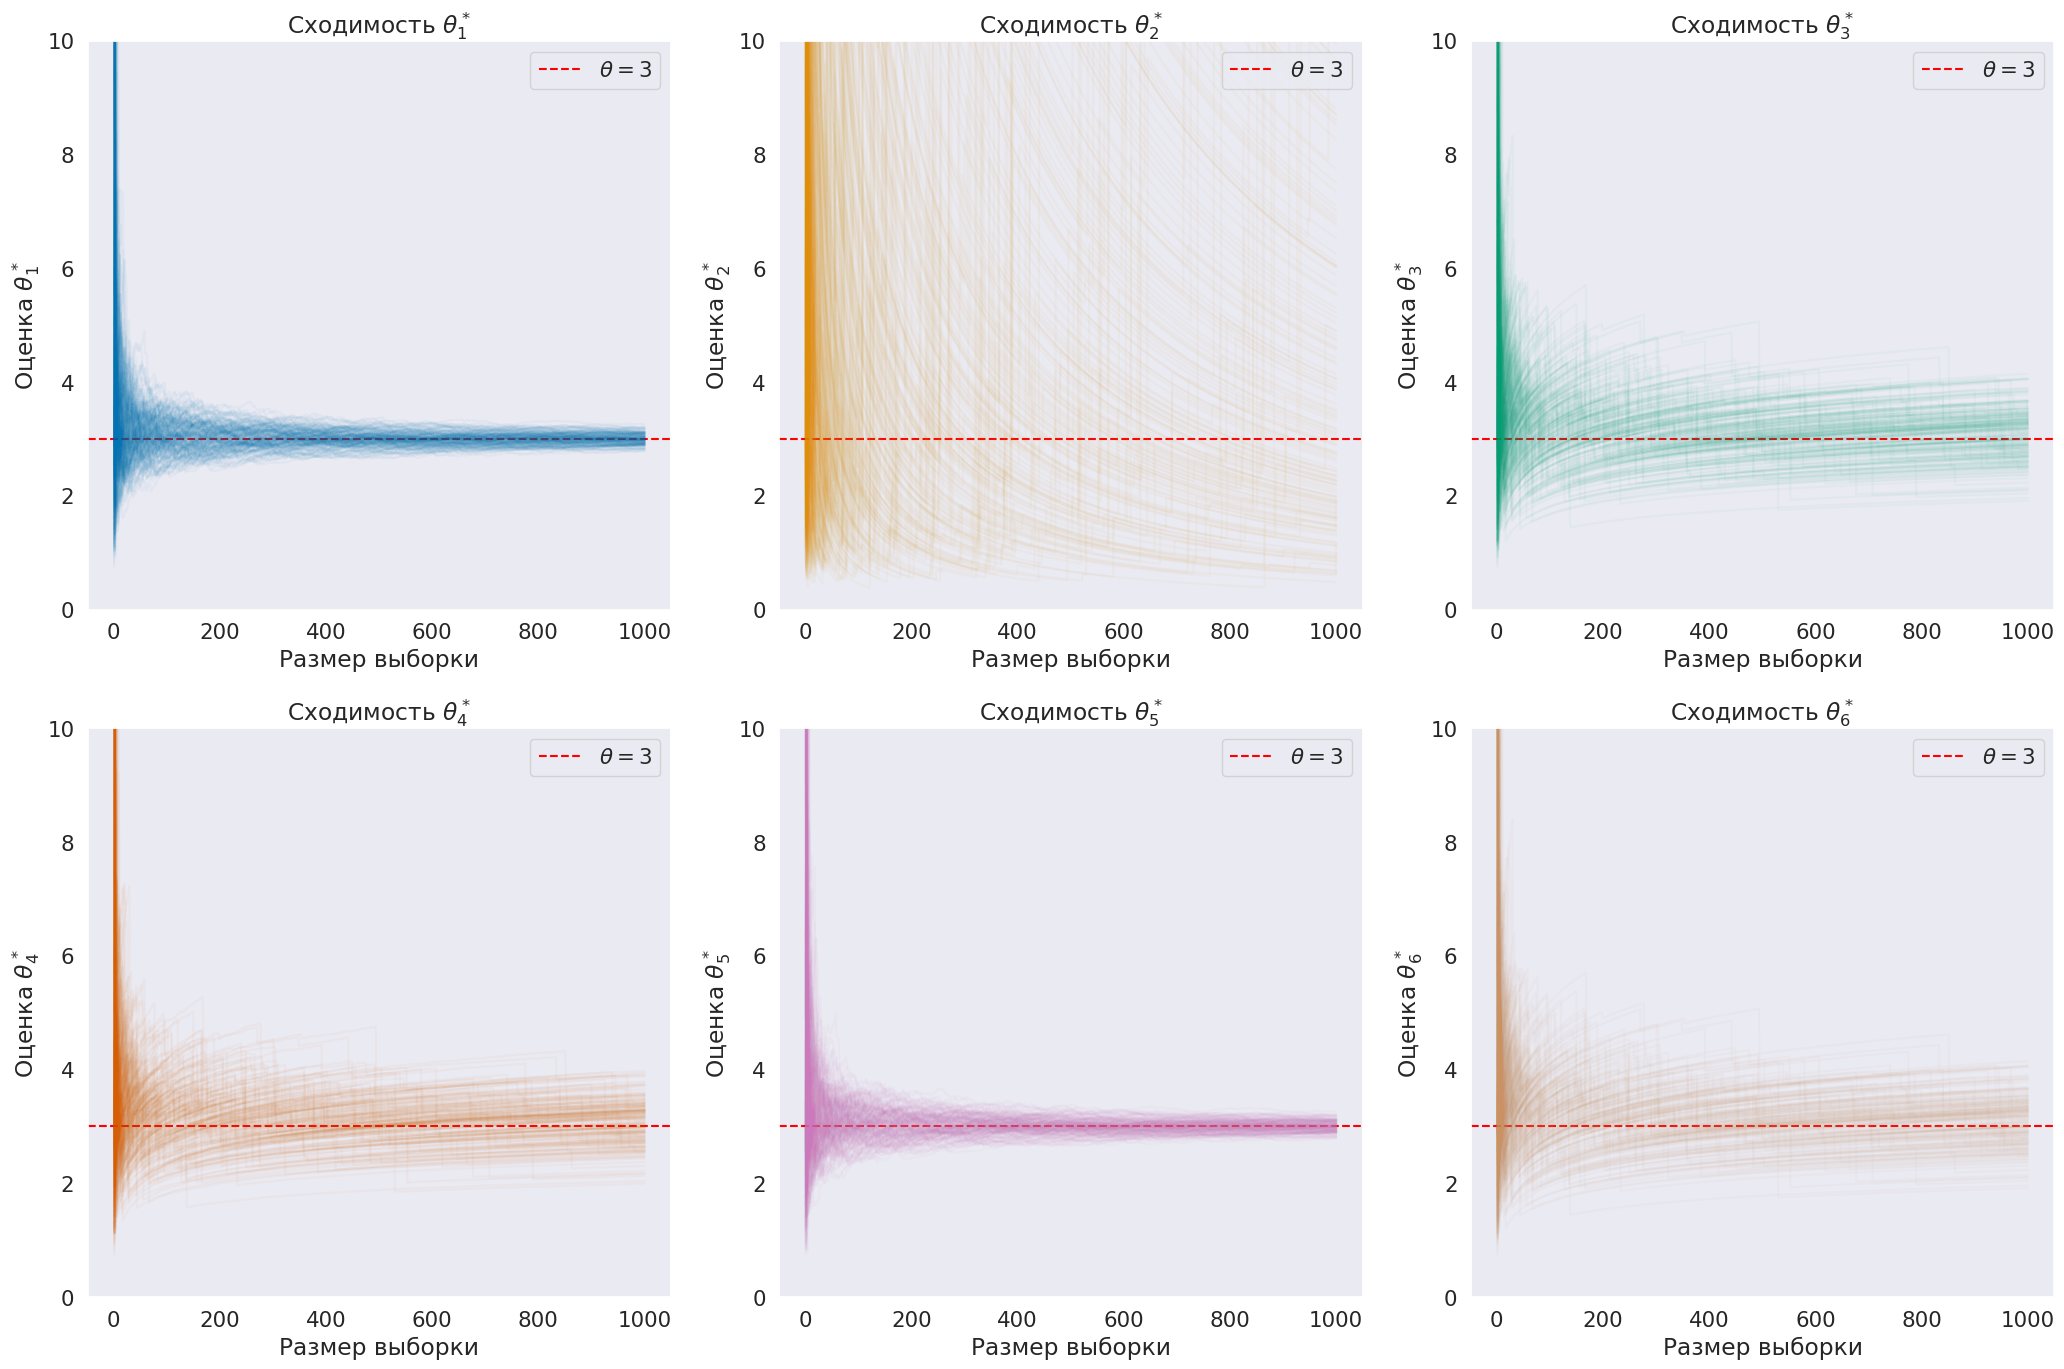

In [99]:
fig, ax = plt.subplots(2, 3, figsize=(21, 14))

for i in range(6):
    ax[i // 3, i % 3].axhline(y=THETA, color='red', linestyle='--', label=r'$\theta = 3$')
    ax[i // 3, i % 3].plot(np.arange(1, N+1), P_collection[i].T, color=colors[i], alpha=0.04)
    ax[i // 3, i % 3].set_xlabel("Размер выборки")
    ax[i // 3, i % 3].set_ylabel(fr"Оценка $\theta^*_{i + 1}$")
    ax[i // 3, i % 3].set_title(fr"Сходимость $\theta^*_{i + 1}$")
    ax[i // 3, i % 3].grid()
    ax[i // 3, i % 3].set_ylim(0, 10)
    ax[i // 3, i % 3].legend()

plt.tight_layout()
plt.show()

Итог такой: оценки 1 и 5 эмпирически сходятся быстрее всего к истинному значению параметра, далее следует оценка 4, и чуть меньше от нее отстают 3 и 6 оценки, которые даже может быть и не сходятся, так как на графике не видно тенденции приближения к настоящему параметру. Вторая же оценка совсем плохая что видно из графика. В целом, это согласуется с графиками плотностей, которые рисовали в 1 задании, и с подсчитанными рисками оттуда же.


2. Есть два замечательных распределения, которые игнорировать никак нельзя. Первое --- $Pareto(k)$ с плотностью $p(x) = kx^{-k-1} I( x \ge 1)$, где $k > 0$. Второе --- $Cauchy(0, \theta)$  с плотностью $p(x) = \frac{\theta}{x^2 + \theta^2}$. Запишите оценки методом моментов для них и проверьте их на состоятельность на практике. Для моделирования возьмите то же значение параметра, что дано выше.

*Подсказка:* внимательно изучите, чему равны моменты каждого из распределений и при каких условиях. Можно ли гарантировать состоятельность полученных оценок каким-то теоретическими фактами?

Решение (аналитический вывод оценок):  
Для распределения Коши самостоятельно не получилось, можно взять с семинара, но это нечестно как-то.  
Для Парето: $$\overline X = E_{\hat k}X = \int\limits_1^{+\infty}\hat kx^{-\hat k}dx = [\text{только при k > 1}] = \frac{\hat k}{\hat k - 1} \Rightarrow \hat k = \frac{\overline X}{\overline X - 1}$$
Состоятельность можем гарантировать по УЗБЧ.

Моделирование:

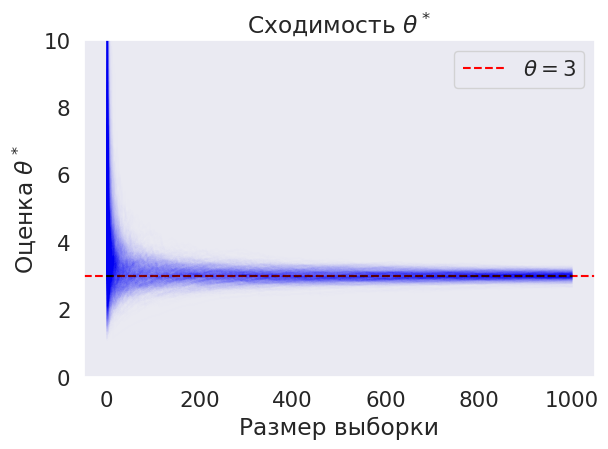

In [109]:
N = 1000
sample_sizes = np.arange(1, N + 1)

def pareto_estimate(pareto_sample):
    pareto_mean = np.cumsum(pareto_sample) / sample_sizes
    return pareto_mean / (pareto_mean - 1)

X = sps.pareto.rvs(THETA, size=(N, N))
sample_sizes = np.arange(1, N + 1)
pareto_mean = np.cumsum(X, axis=1) / sample_sizes
pareto_est = pareto_mean / (pareto_mean - 1)

plt.plot(figsize=(7, 7))
plt.axhline(y=THETA, color='red', linestyle='--', label=r'$\theta = 3$')
plt.plot(np.arange(1, N+1), pareto_est.T, color='blue', alpha=0.003)
plt.xlabel("Размер выборки")
plt.ylabel(fr"Оценка $\theta^*$")
plt.title(fr"Сходимость $\theta^*$")
plt.grid()
plt.ylim(0, 10)
plt.legend()

plt.tight_layout()
plt.show()

**Вывод:**  
Проверили, что метод моментов действительно является хорошим. Для распределения Парето проверили, что полученная оценка является состоятельной и теоретически, и практически, промоделировав её на графике.